In [1]:
import argparse
import importlib.util

import tensorflow as tf
import h5py
import pickle
import matplotlib.pyplot as plt

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import *
from data.hlf_preprocessing import load
from evaluation.histogram_builder import *
from evaluation.plot_utils import *

In [2]:
result_path = '/home/oliverkn/pro/alad_6021/2_l16_1'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))

loading alad


W1016 22:05:11.048847 139845725378368 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1016 22:05:11.081596 139845725378368 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1016 22:05:11.085627 139845725378368 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1016 22:05:11.086599 139845725378368 deprecation.py:323] From /home/oliverkn/pro/alad_6021/2_l16_1/config.py:81: dense (from te

In [3]:
score_type = 'fm'

def build_hists(x, n_max, eff, preselect, batch_size=2 ** 20, build_ano=True):
    hist_builder_all = HistogramBuilder(settings_6021)
    hist_builder_anomalous = HistogramBuilder(settings_6021)

    n = x.shape[0]
    n = min(n, n_max)

    n_batches = int(n / batch_size) + 1
    for t in range(n_batches):
        print('batch number ' + str(t))

        ran_from = int(t * batch_size)
        ran_to = (t + 1) * batch_size
        ran_to = int(np.clip(ran_to, 0, n))
        x_batch = x[ran_from:ran_to]
        
        # preselection
        if preselect:
            filter_iso = x_batch[:,7]+x_batch[:,8]+x_batch[:,9] < 0.15
            filter_eta = np.abs(x_batch[:,5]) < 1
            filter_njets = x_batch[:,2] > 0

            filter_idx = filter_iso * filter_eta * filter_njets
            x_batch = x_batch[filter_idx]
        
        hist_builder_all.add_data(x_batch)
        
        if build_ano:
            x_batch_transformed = preprocessor.transform(x_batch)
            scores = ad.get_anomaly_scores(x_batch_transformed, type=score_type)
            thres = np.quantile(scores, 1.-eff)
            
            anomaly_idx = scores >= thres
            hist_builder_anomalous.add_data(x_batch[anomaly_idx])
        
    return hist_builder_all.get_histogram_data(), hist_builder_anomalous.get_histogram_data()
    

In [34]:
# build ttbar
file_ttbar = '/home/oliverkn/pro/9588/data.hdf5'
x = h5py.File(file_ttbar, "r")['data']
hist_ttbar, _ = build_hists(x, n_max=1e6, build_ano=False)

batch number 0


In [9]:
n_max = 20e6
eff = 200e-6
preselect = False

# build data
file_data = '/home/oliverkn/pro/6021/data.hdf5'
x_data = h5py.File(file_data, "r")['data']
hist_data, hist_data_ano = build_hists(x_data, n_max=n_max, eff=eff, preselect = preselect)
print('anomalous events: %d' % hist_data_ano['HT']['n'])
print('anomalous fraction: %3d_ppm' % (hist_data_ano['HT']['n'] / hist_data['HT']['n']*1e6))

# build mc
file_mc = '/home/oliverkn/pro/wjets_dyjets_mix/data.hdf5'
x_mc = h5py.File(file_mc, "r")['data']
hist_mc, hist_mc_ano = build_hists(x_mc, n_max=n_max, eff=eff, preselect = preselect)
print('anomalous events: %d' % hist_mc_ano['HT']['n'])
print('anomalous fraction: %3d_ppm' % (hist_mc_ano['HT']['n'] / hist_mc['HT']['n']*1e6))

# build mc+ttbar
file_ttbar = '/home/oliverkn/pro/9588/data.hdf5'
x_ttbar = h5py.File(file_ttbar, "r")['data']
x_mc = h5py.File(file_mc, "r")['data']
fractions =  np.array([7027, 136.3])
fractions = fractions / np.sum(fractions)
x_mc_ttbar = compile_mix([x_mc, x_ttbar], fractions)
hist_ttbar, hist_ttbar_ano = build_hists(x_mc_ttbar, n_max=n_max, eff=eff, preselect = preselect)
print('anomalous events: %d' % hist_ttbar_ano['HT']['n'])
print('anomalous fraction: %3d_ppm' % (hist_ttbar_ano['HT']['n'] / hist_ttbar['HT']['n']*1e6))

batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6
batch number 7
batch number 8
batch number 9
batch number 10
batch number 11
batch number 12
batch number 13
batch number 14
batch number 15
batch number 16
batch number 17
batch number 18
batch number 19
anomalous events: 4005
anomalous fraction: 200_ppm
batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6
batch number 7
batch number 8
anomalous events: 1888
anomalous fraction: 200_ppm
batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6
batch number 7
batch number 8
batch number 9
anomalous events: 1925
anomalous fraction: 200_ppm


saving fig to data_vs_mc.pdf


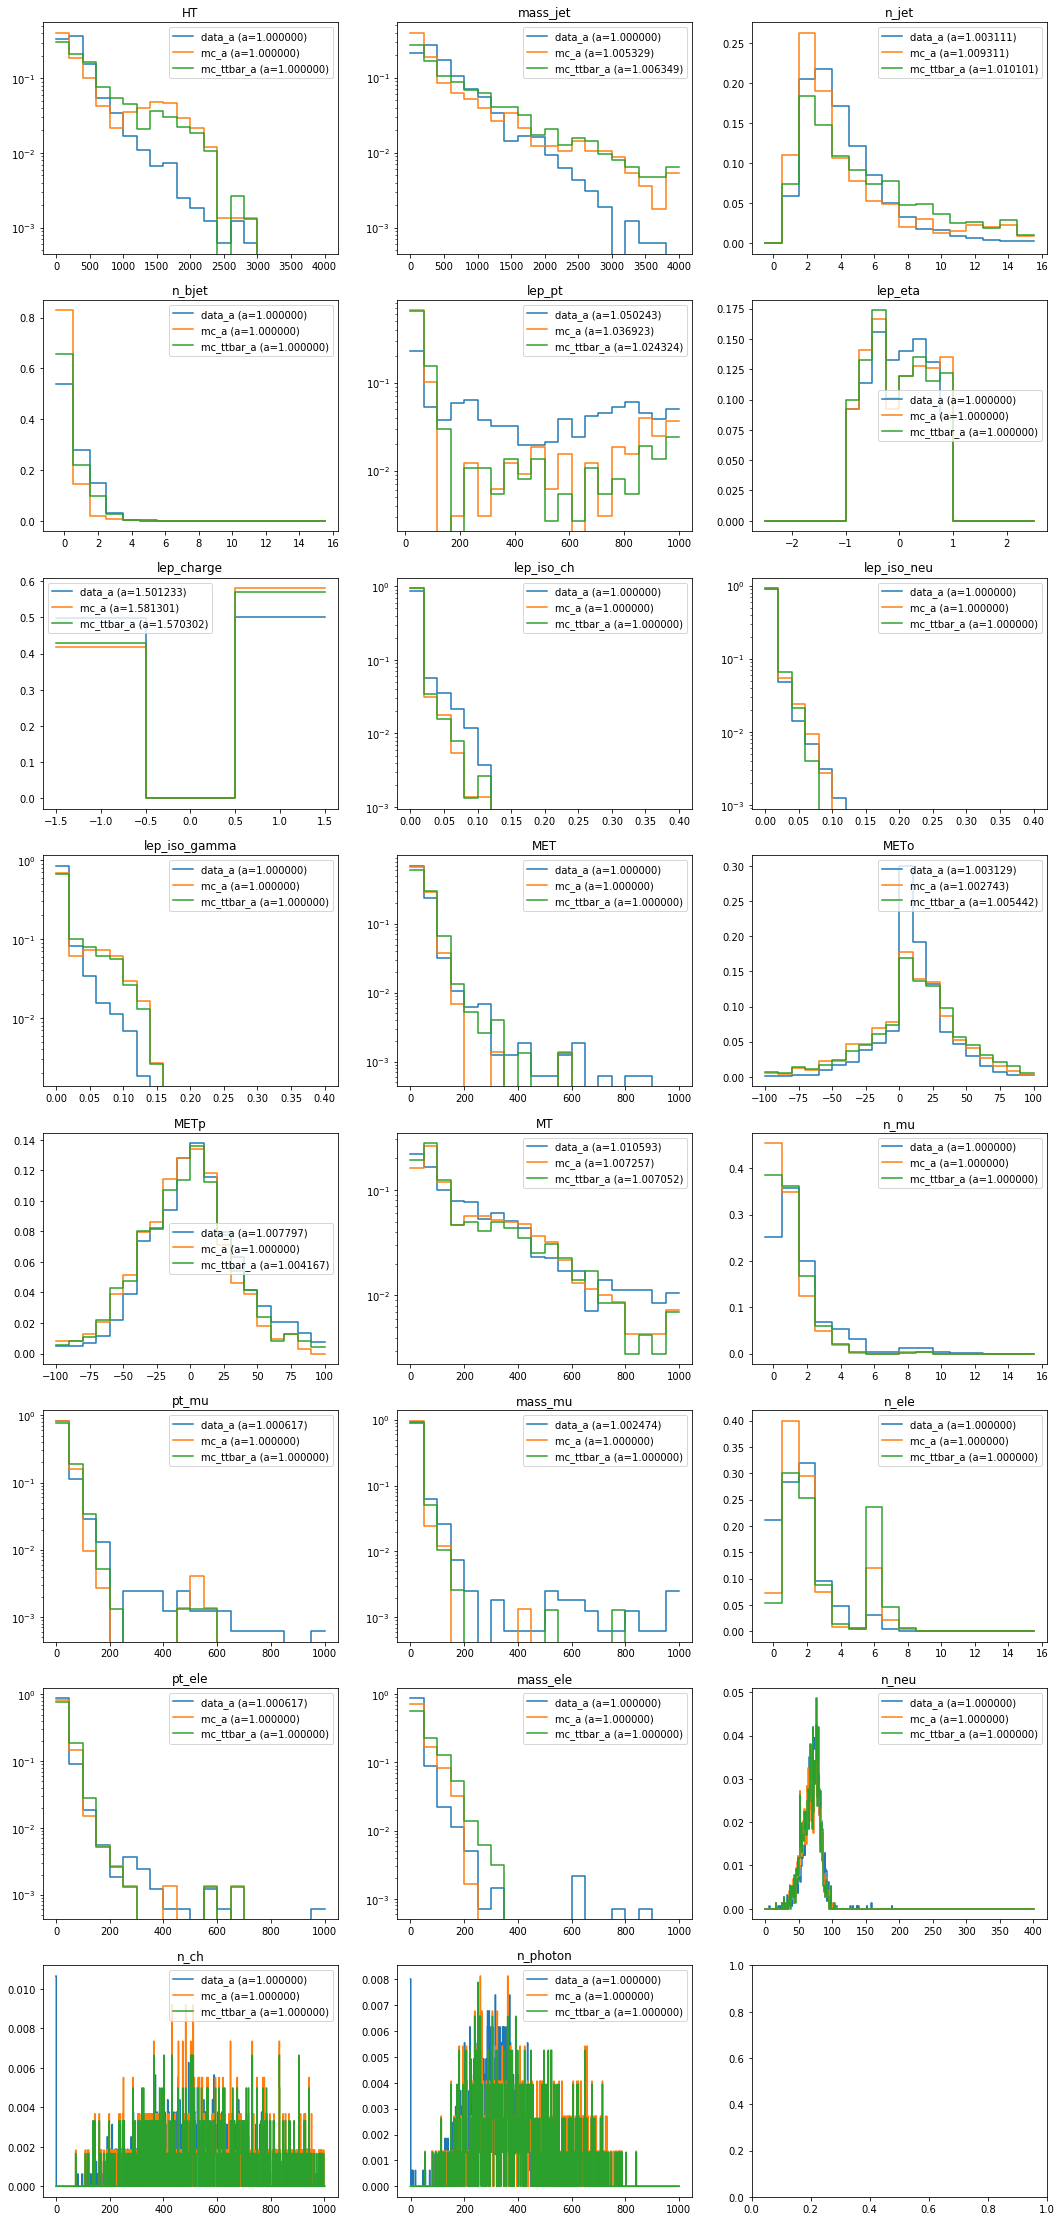

In [8]:
plot_hist([hist_data_ano, hist_mc_ano, hist_ttbar_ano], ['data_a','mc_a', 'mc_ttbar_a'], settings_6021, output_file='data_vs_mc.pdf')
#plot_hist([hist_data_ano, hist_mc_ano, hist_ttbar], ['data','mc','ttbar'], settings_6021, output_file='data_vs_mc.pdf')
#plot_hist([hist_data,hist_mc,hist_data_ano, hist_mc_ano, hist_ttbar], ['data all','mc all','data','mc','ttbar'], settings_6021)

saving fig to data_adj.pdf


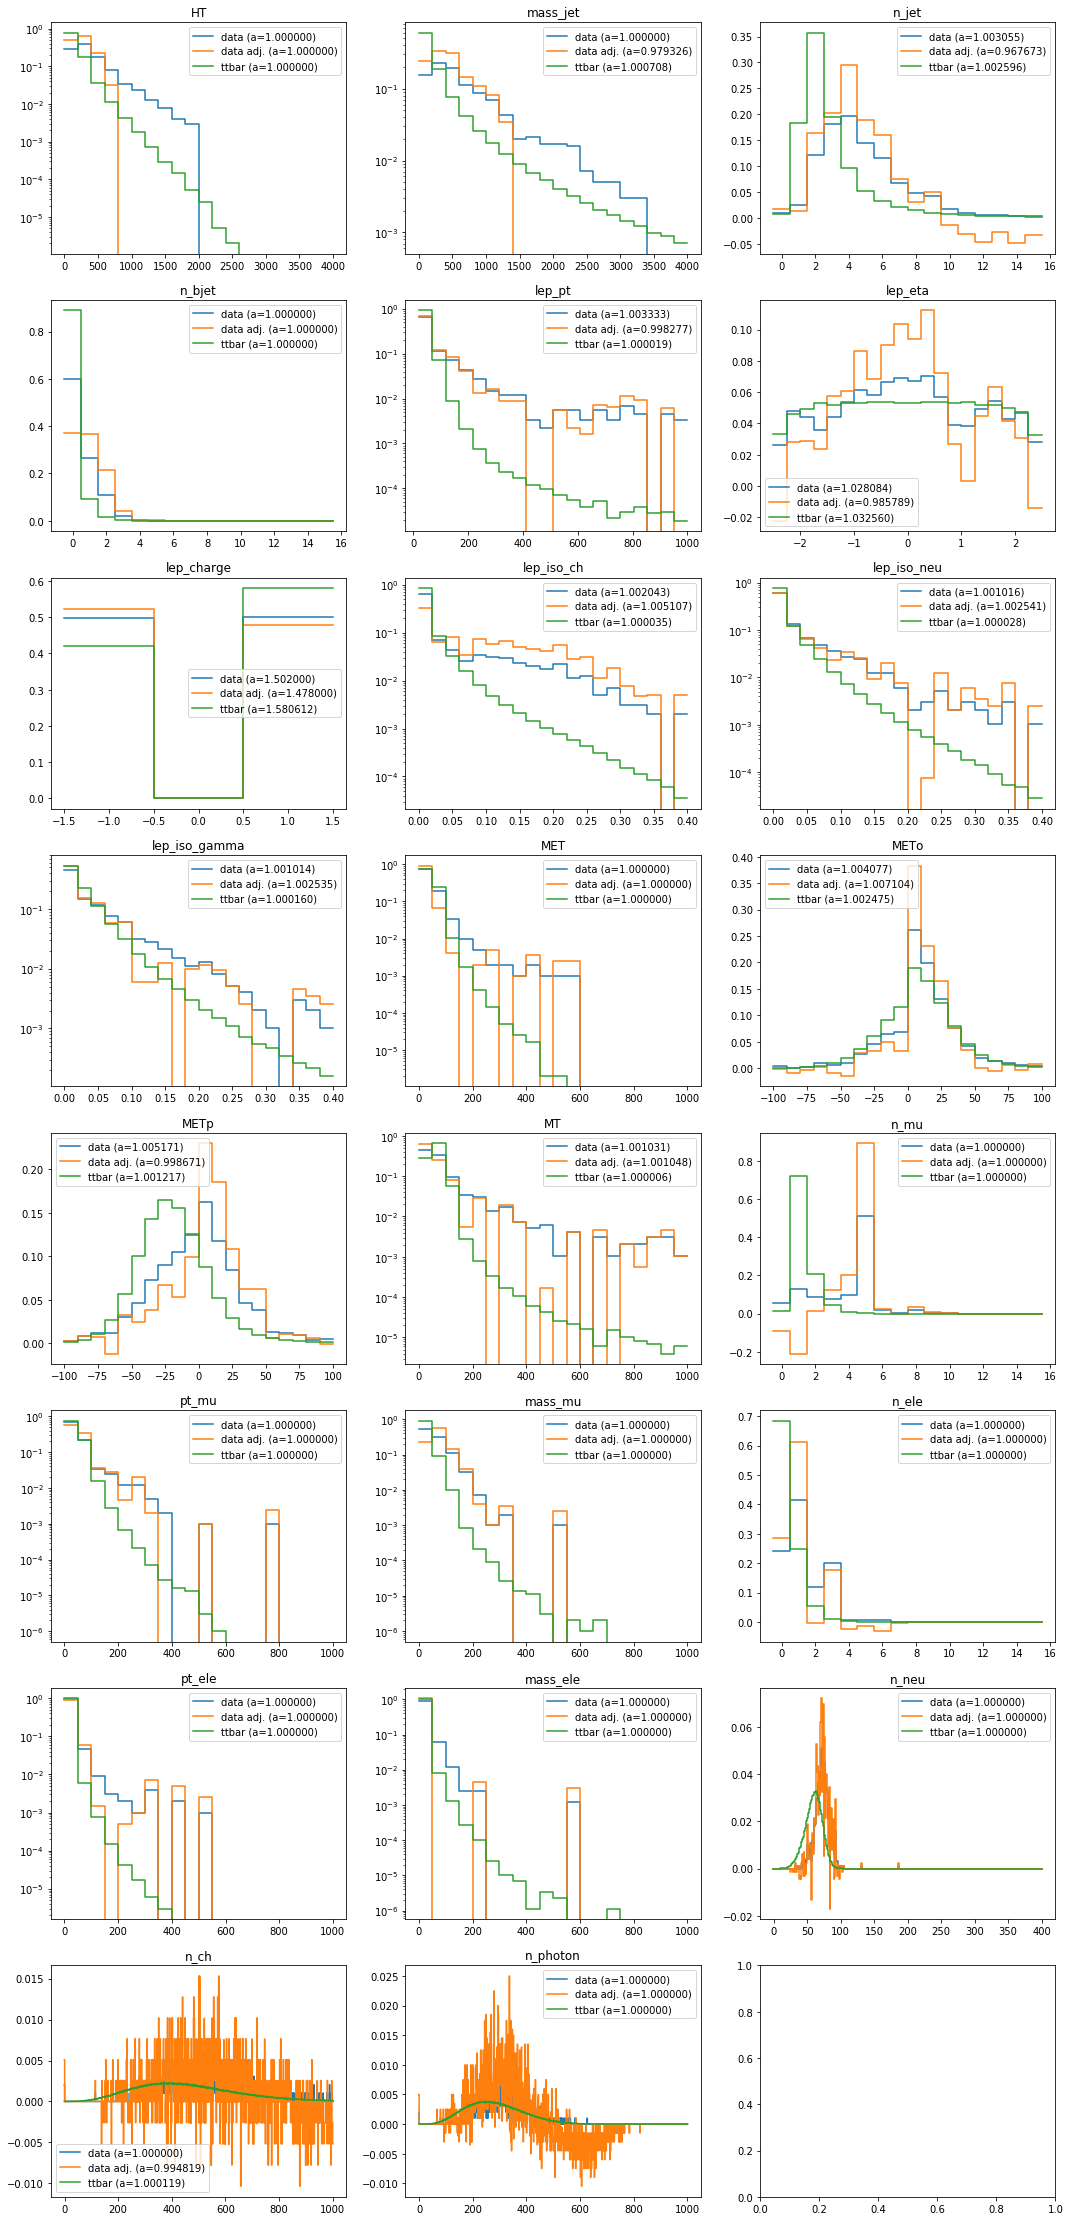

In [32]:
w=0.6

hist_delta = {}
for name in hist_data_ano.keys():
    hist_delta[name] = {}
    hist_delta[name]['bin_edges'] = hist_data_ano[name]['bin_edges']
    noise = hist_mc_ano[name]['pdf']
    #noise = noise * hist_data[name]['pdf']/hist_mc[name]['pdf']
    hist_delta[name]['pdf'] = (hist_data_ano[name]['pdf'] - w*noise)/(1-w)
    
plot_hist([hist_data_ano, hist_delta, hist_ttbar], ['data','data adj.','ttbar'], settings_6021,output_file='data_adj.pdf')

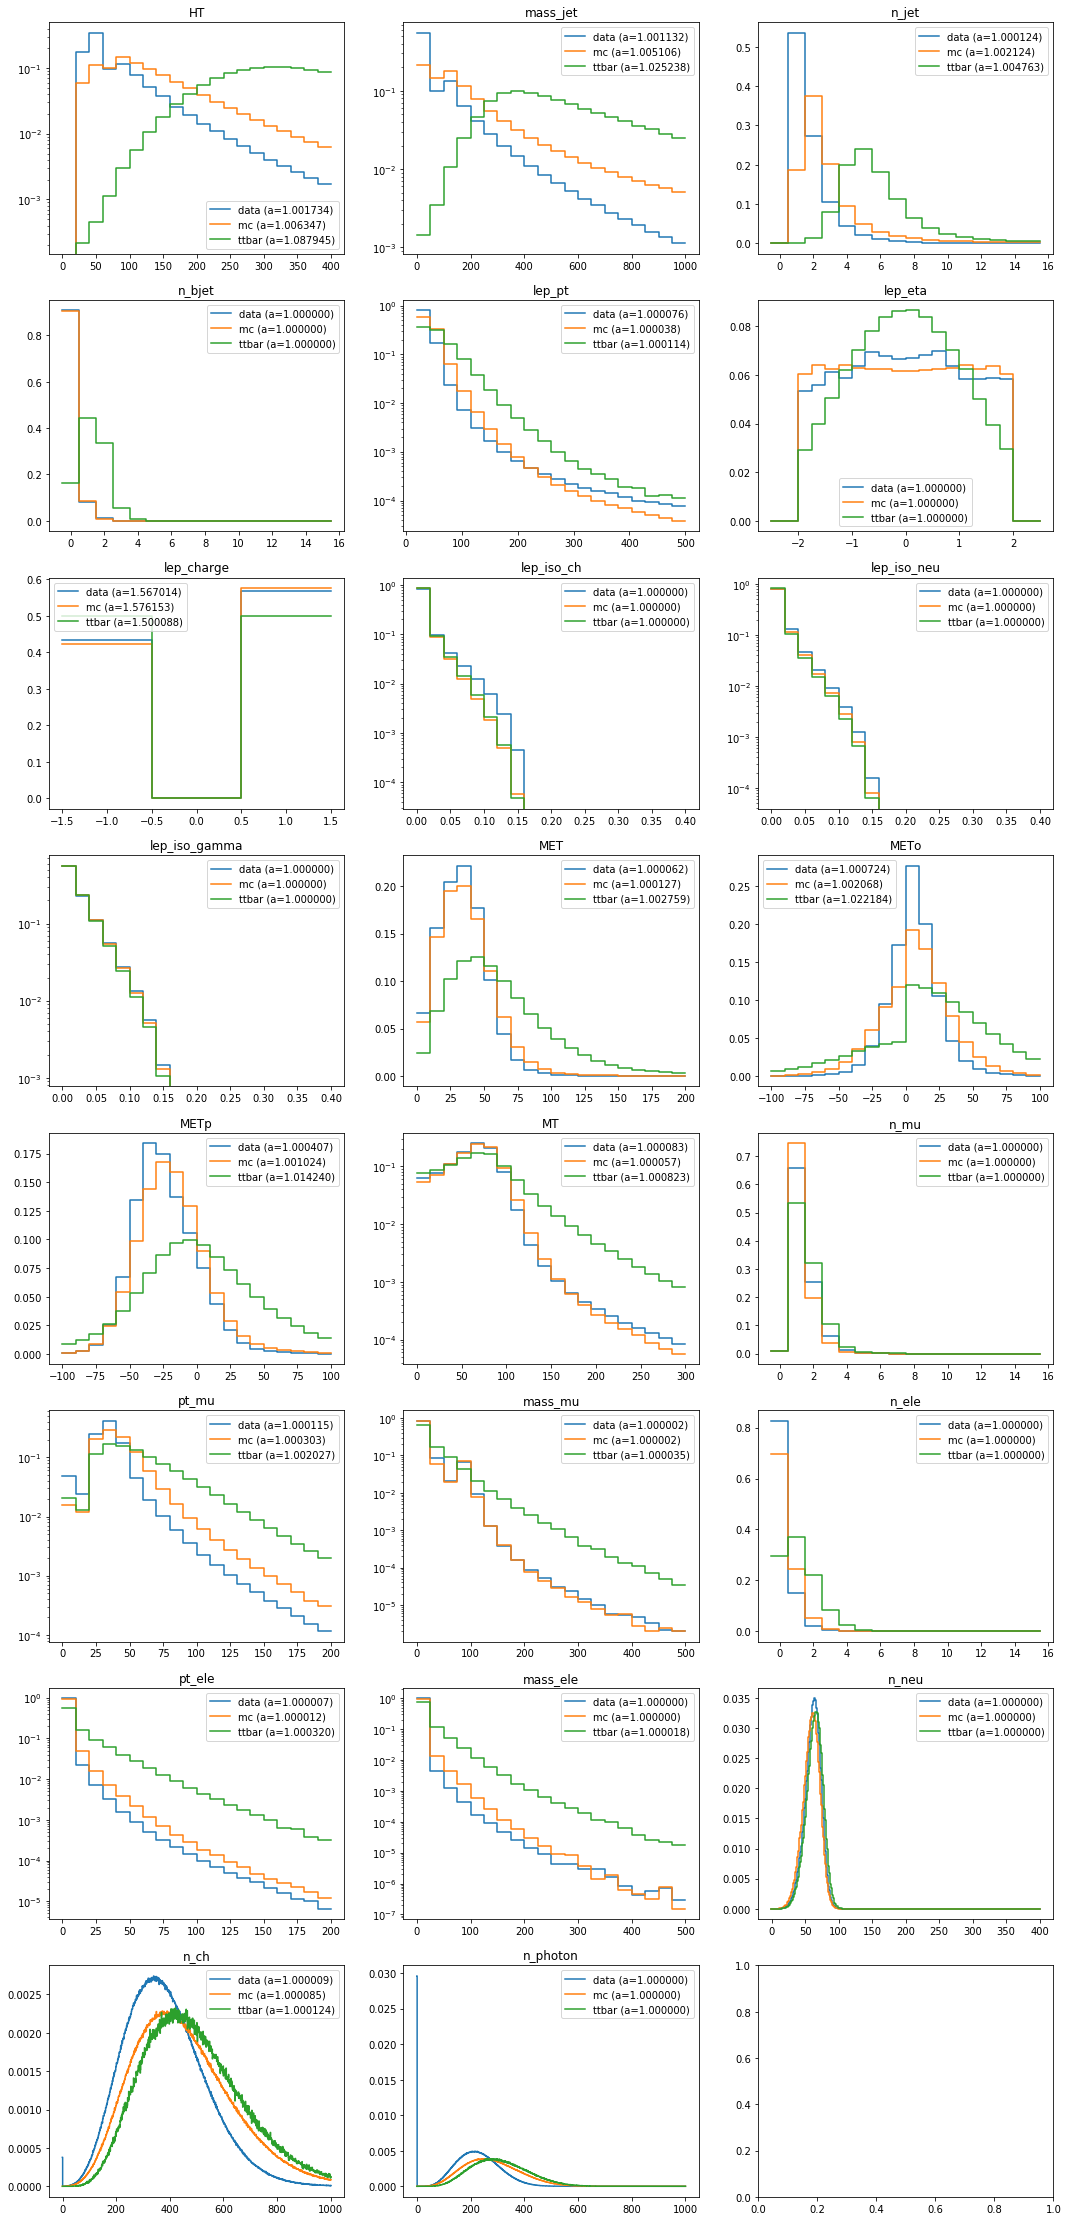

In [16]:
plot_hist([hist_data, hist_mc, hist_ttbar], ['data','mc','ttbar'], settings_6021)

In [ ]:
hist_file_all = os.path.join(target, 'all.pkl')
hist_file_normal = os.path.join(target,'%3d_ppm' % (n_anomalous / n_tot*1e6)+'_n.pkl')
hist_file_anomalous = os.path.join(target,'%3d_ppm' % (n_anomalous / n_tot*1e6)+'_a.pkl')

print('saving data to ' + hist_file_all)
pickle.dump(hist_data_all, open(hist_file_all, 'wb'))

print('saving normal data to ' + hist_file_normal)
pickle.dump(hist_data_normal, open(hist_file_normal, 'wb'))

print('saving anomalous data to ' + hist_file_anomalous)
pickle.dump(hist_data_anomalous, open(hist_file_anomalous, 'wb'))